# Analysing a population of gravitational-waves

### What is the question?

In previous sessions, you have learned how to extract the gravitational-wave source properties given a time series of strain.
Now we bring the question one step further: given a set of gravitational-wave events and their properties, such as masses, extract the physics behind this distribution of events. In other words, we are trying to understand the conditional probability $p(\mathbf{\lambda}|\{\mathbf{d}\})$, where $\mathbf{\lambda}$ is a vector of the population parameters which characterizes the behaviour of a particular population model, and $\{\mathbf{d}\}$ is the set of events.

### Goal of this session

By the end of this session, you should have a rough idea of how to analyse a population of gravitational waves (GWs), including some technical detail such as how a typical catalogue of GWs looks like (for e.g. GWTC2 https://arxiv.org/pdf/2010.14527.pdf) and what a selection function is.

In particular, you should  be able to answer the following questions:

1. What is the form of the population posterior?
2. How uncertainty of an individual event is handled on a population level?
3. What is the definition of selection bias?

On top of the core session, we will try analyse the population of binary black holes (BBHs) in the most updated gravitational-wave catalogue (GWTC2 at this point).
For simplicity, we will analyse the mass distribution using the simplest model --- truncated power law. The answer we will get is not going to be correct, but it should give some insights on how to interpret the properties of a population of BBHs.

### Theory setup

The detail derivation of what we need in this session can be found on https://arxiv.org/pdf/1809.02063.pdf. Here we will give a much more condense (handwavy) version of 

First, we use Bayes theorem to rewrite what we want into what we have access to
$$
p(\mathbf{\lambda}|\{\mathbf{d}\}) = \frac{p(\{\mathbf{d}\}|\mathbf{\lambda})\pi(\mathbf{\lambda})}{p(\{\mathbf{d}\})},
$$

where $p(\{\mathbf{d}\}|\mathbf{\lambda})$ is the likelihood, our model of the population, which is usually obtained either by writing down phenomenological models or through simulations;
$\pi(\mathbf{\lambda})$ is the prior, which encodes our knowledge on what the physical system should look like. For example, mass should not be negative, so the minimum mass in a truncated power law mass model cannot be smaller than 0;
$p(\{\mathbf{d}\})$ is the evidence, which is often used in model selection. You may notice this term does not depend on $\mathbf{\lambda}$, so it is a constant across all the parameter we are interested, meaning we can ignore it during the inference process.

The next step is to assume the events we have are independent, i.e. the parameter estimation process of one event does not affect another. This allows us to factorize the likelihood into the form

$$
p(\{\mathbf{d}\}|\mathbf{\lambda}) = \displaystyle \prod^{N}_{i} p(\mathbf{d}_i|\mathbf{\lambda}).
$$

In principle one can write down a model which predict the data $\mathbf{d}_i$ directly, which is usually in the form of a time series of strain. However this is obviously unnecessarily expensive since we have all the LVC infrastructure for reducing a high dimensional data (the time series) to a lower dimensional representation (source parameters). To leverge the product of LVC parameter estimation pipeline, we can use the marginalization rule of probility to expand our likelihood

$$
p(\mathbf{d}_i|\mathbf{\lambda}) = \int p(\mathbf{d}_i|\mathbf{\theta}_i)p(\mathbf{\theta}_i|\mathbf{\lambda}) d\mathbf{\theta}_i.
$$

For clarity, we will name $\mathbf{\theta}$ as the source parameters, and $\mathbf{\lambda}$ as the population parameters.

Since not all events can be detected, models predicting more weak signal will tend to be panelized unfairly in the inference process. To compensate for this panelty, we need to upweight those panelized models. Conventionally, this is done by multiplying the likelihood by the selection bias

$$
p(\lambda|\{\mathbf{d}\}) = \pi(\lambda)\displaystyle \prod_{i}^{N}\int \frac{p(\mathbf{d}_i|\mathbf{\theta}_i)p(\theta_{i}|\lambda)}{\alpha(\lambda)} d\mathbf{\theta}_i.
$$

Finally, since data product released by the LVC is in the form of posterior samples instead of likelihood, we need to rewrite the individual likelihood $p(\mathbf{d}_i|\mathbf{\theta}_i)$ into the individual posterior $p(\mathbf{\theta}_i|\mathbf{d}_i|)$. Combining this with importance sampling (https://en.wikipedia.org/wiki/Importance_sampling), we can rewrite the integral into the form of 

$$
p(\lambda|\{d\}) = \pi(\lambda)\displaystyle \prod_{i}^{N}\frac{1}{S}\displaystyle\sum_{j}^{S}
\frac{p(\theta_{i,j}|\lambda)}{\pi(\theta_{i,j})\alpha(\lambda)},
$$

where $S$ denotes the number of posterior samples in each individual event. This form of the posterior is what we will use in this tutorial. Note that in principal we can also use rate information to constrain our model. Since that is relatively trivial, we will not include that in this tutorial.


#### Here we import the packages we will use for this tutorial. I also put some useful plotting functions here for visualization.

In [827]:
# Importing packges we need

import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import h5py
from astropy.cosmology import Planck15
import astropy.units as u
from multiprocessing import Pool
np.random.seed(0)
%matplotlib inline

In [828]:
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from scipy.ndimage import gaussian_filter
params = {'axes.labelsize': 32,
          'font.family': 'serif',
          'font.serif': 'Computer Modern Raman',
          'font.size': 32,
          'axes.linewidth': 2,
          'legend.fontsize': 28,
          'xtick.labelsize': 28,
          'xtick.top': True,
          'ytick.labelsize': 20,
          'ytick.right': True,
          'axes.grid' : False,
          'text.usetex': True,
          'savefig.dpi' : 100,
          'lines.markersize' : 14,
#          'axes.formatter.useoffset': False,
          'axes.formatter.limits' : (-3,3)}

mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command

mpl.rcParams.update(params)

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.


In [829]:
def fill_corner(fig,data,ndim,axis,color='C0',true_val=None,zorder=1,lw=3,style='-',smooth1d = 0.01,no_fill_contours=False,fill_contours=True,alpha=1,levels=[0.68,0.95]):
    for i in range(ndim):
        for j in range(i+1):
            ax = fig.axes[np.sum(np.arange(i+1))+j]
            if i==j:
                ax.hist(data[i],bins=axis[i],histtype='step',lw=lw,color=color,density=True,zorder=zorder)
                ylim = ax.get_ylim()
                ax.set_xlim(axis[i][0],axis[i][-1])
                ax.set_ylim(ylim[0],ylim[1])
                if true_val is not None:
                    ax.vlines(true_val[i],ylim[0],ylim[1],color=color,lw=lw,zorder=zorder)

            elif j<i:
                corner.hist2d(data[j],data[i],bins=[axis[j],axis[i]],plot_datapoints=False,plot_density=False,ax=ax,levels=levels,fill_contours=fill_contours,smooth1d = smooth1d,color=color,no_fill_contours=True,contour_kwargs={'linewidths':lw,'zorder':zorder,'linestyles':style,'colors':color})
                ax.set_ylim(axis[i][0],axis[i][-1])
                ax.set_xlim(axis[j][0],axis[j][-1])
                if true_val is not None:
                    ax.scatter(true_val[j],true_val[i],color=color,marker='*',s=100,zorder=20)
                    ax.vlines(true_val[j],ax.get_ylim()[0],ax.get_ylim()[1],color=color,lw=3)
                    ax.hlines(true_val[i],ax.get_xlim()[0],ax.get_xlim()[1],color=color,lw=3)


# Toy example - Gaussian distribution

We first look at a simplistic example to understand the crux of hierarchical Bayesian, a one-dimensional Gaussian, which is characterized by two parameters, the mean $\mu$ and standard deviation $\sigma$.

$$
p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\frac{(x-\mu)^2}{\sigma^2}}
$$

Let's start without considering the effect of measurement uncertainty and selection effect. In this case, the population posterior looks like the following:

$$
p(\lambda|\{d\}) = \pi(\lambda)\displaystyle \prod^{N}_{i}p(\theta_i|\lambda)
$$
As a first step, I have given you an example code on how to generate and analyse this particular set up we have.
Read through it, trying answering the checkpoints question in the code, then modify the code to address the question in the exercise.


In [898]:
def gaussian(x,mean,sigma):
    return (1./np.sqrt(2*np.pi)/sigma)*np.exp(-(((x-mean)/sigma)**2)/2)

def population_likelihood(params, data):
    # Checkpoint 1, what are these lines doing 
    if (params[0]>10) or (params[0]<-10):
        return -np.inf
    if (params[1]>5) or (params[1]<0):
        return -np.inf
    # End of Checkpoint 1
    output = np.sum(np.log(gaussian(data,params[0],params[1]))) # Checkpoint 2, what is this line doing? How does it compared to the full form we have in the introduction?
    if np.isfinite(output):
        return output
    else:
        return -np.inf

In [899]:
true_mean = 1
true_sd = 1
N_obs = 100
injection = np.random.normal(true_mean,true_sd,size=N_obs)

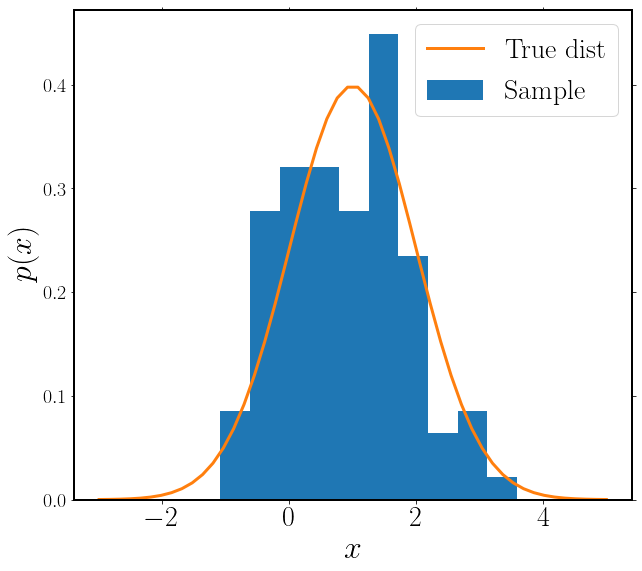

In [900]:
fig, ax = plt.subplots(1,1,figsize=(10,9))
plt.hist(injection,density=True,label='Sample',bins=10)
plt.plot(np.linspace(-3,5),gaussian(np.linspace(-3,5),true_mean,true_sd),lw=3,label='True dist')
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')

In [901]:
# This is the sampling package emcee we use to sample our posterior function. For more reference see https://emcee.readthedocs.io/en/stable/
ndim, nwalkers = 2, 100
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_likelihood, args=[injection])
sampler.run_mcmc(p0, 1000)

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/home/kaze/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[ 0.86911653  0.8958617 ]
 [ 0.82308002  0.91172746]
 [ 0.8831504   1.06340567]
 [ 0.90460809  1.10488576]
 [ 0.97519425  1.06587311]
 [ 0.81506477  1.07371185]
 [ 0.88419629  0.93917323]
 [ 0.78634373  1.03959245]
 [ 0.9600721   0.87939174]
 [ 0.79026465  0.86841284]
 [ 1.08088534  1.06729762]
 [ 0.95260907  0.92595412]
 [ 1.01840295  0.97772157]
 [ 0.89871283  1.03998265]
 [ 0.86127168  1.03938366]
 [ 1.03249831  1.01319192]
 [ 0.99243227  1.04763693]
 [ 0.88746833  1.06017983]
 [ 0.84201107  0.93713643]
 [ 0.90499308  0.87762061]
 [ 0.41426523 -1.27673134]
 [ 0.89165342  1.10058362]
 [ 0.89248503  0.94995407]
 [ 0.96378732  1.00143826]
 [ 0.94611908  0.93291844]
 [ 0.85455968  0.95539462]
 [ 0.88626434  1.00963254]
 [ 1.0200215   1.0967899 ]
 [ 0.88722768  0.9747894 ]
 [ 0.82832558  1.02837358]
 [ 0.9127569   0.95940676]
 [-1.0860153  -0.95779387]
 [ 1.06549144  1.02315517]
 [-0.7511694  -1.43502662]
 [ 1.21381783  1.20724911]
 [ 0.92188637  0.9534639 ]
 [ 0.98786186  0.94300

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, '')

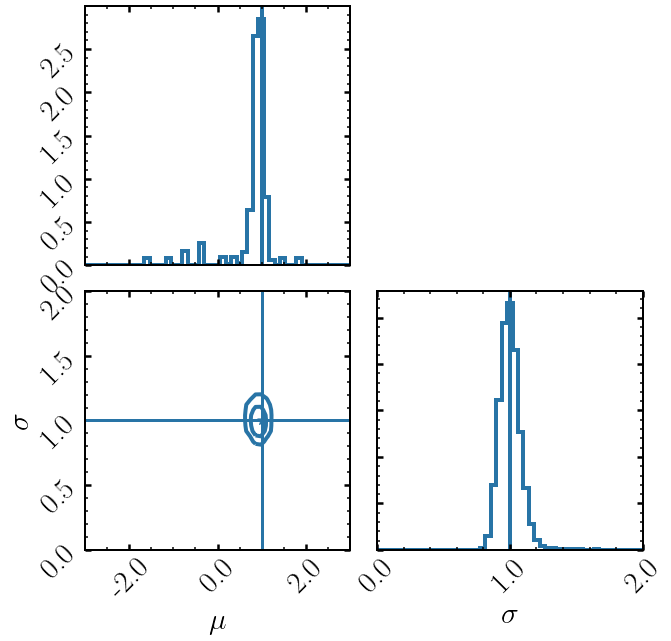

In [902]:
# This is a snippet of code which I use to plot corner plot, default corner plot doesn't allow some flexibility we need.
Ndim = 2
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(Ndim,Ndim,wspace=0.1,hspace=0.1)
Nbins = 50
axis = np.array([np.linspace(-3,3,Nbins),np.linspace(0,2,Nbins)])
xlabel = [r'$\mu$',r'$\sigma$']

for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.add_subplot(grid[i,j])

        
colors = ['#2874A6','#b11226']

fill_corner(fig,sampler.flatchain.T,Ndim,axis,colors[0],style=['-'],fill_contours=False,lw=4,true_val=[1,1])

counter = 0
for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.axes[counter]
        if i!=Ndim-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(xlabel[j],fontsize=30)
            ax.set_xticklabels(np.around(ax.get_xticks(),1),rotation=45,fontsize=30)
        if j!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(xlabel[i],fontsize=30)
            ax.set_yticklabels(np.around(ax.get_yticks(),1),rotation=45,fontsize=30)
        counter += 1
        ax.tick_params(axis="both",direction="in",which='major',width=2.5,length=6,right=True,top=True)
        ax.tick_params(axis="both",direction="in",which='minor',width=1.5,length=3,right=True,top=True)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        
fig.axes[0].set_ylabel('')


### Exercise

1. Answer the 2 checkpoints in the code.
2. With high number of events, the posterior will approach a gaussian distribution around the true values. Try decreasing the number of events gradually, can you identify the changes in the posterior? Can you explain why the posterior has such as a shape?

# Adding uncertainty in measurement

The next thing we will add in this tutorial is measurement uncertainty in each event.
Ideally we would like every measurement to be perfectly accurate and precise. While we will not add bias in this tutorial, we can add uncertainty in the measurement to worsen the precision of each measurement.

In principal you should generate a catalogue of events, then perform parameter estimation on each of the event to obtain the uncertainty. However that will be too computationally costly for our tutorial. Instead, we will just use another Gaussian distribution to smooth out each measurement. However, bare in mind that this is not the correct thing to do, and you will see some problem of assuming a Gaussian in this section.

Modify the example in the previous session to address the following questions:

1. Write down the form of the population posterior when considering measurement uncertainty.
2. Using the original set of event generated in the previous example (N=100), smooth each event using a Gaussian distribution. You can do this by drawing samples from a Gaussian distribution with $\mu=x_{\rm{true}},\sigma=0.1$. Try moderate amount of sample, such as 100 samples per event. Plot all the samples in one histogram at the end. How does it look compared to the original one?
3. Now modify the likelihood function by adding the feature that mean over samples in each event. Use this new likelihood to analyse the new smoothed-out catagloue. Do you expect this result?
4. Increase the uncertainty on each event gradually, say start with 0.5 then 1. Do you see some unexpected behaviour? Can you explain why is that the case?

In [912]:
def population_likelihood_with_uncertainty(params, data):
    if (params[0]>10) or (params[0]<-10):
        return -np.inf
    if (params[1]>5) or (params[1]<0):
        return -np.inf
    output = np.sum(np.log(np.mean(gaussian(data,params[0],params[1]),axis=0)))
    if np.isfinite(output):
        return output
    else:
        return -np.inf

sigma = 0.1
injection_with_uncertainty = np.random.normal(injection,sigma,size=(100,N_obs))

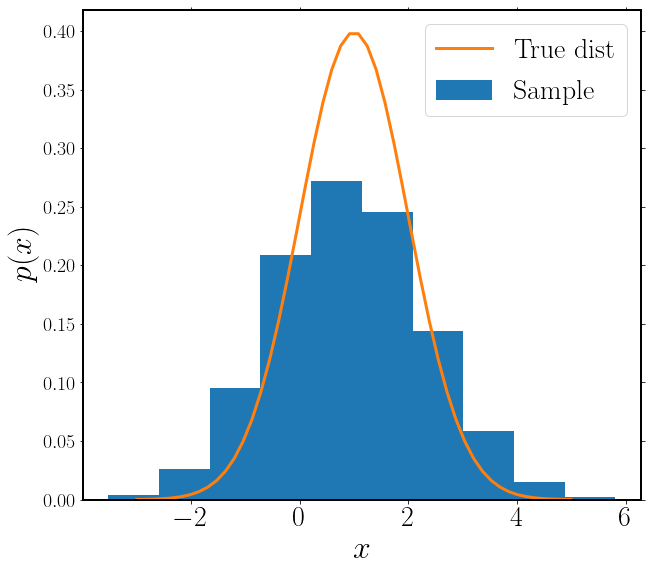

In [909]:
fig, ax = plt.subplots(1,1,figsize=(10,9))
plt.hist(injection_with_uncertainty.flatten(),density=True,label='Sample')
plt.plot(np.linspace(-3,5),gaussian(np.linspace(-3,5),true_mean,true_sd),lw=3,label='True dist')
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')

In [910]:
ndim, nwalkers = 2, 100
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_likelihood_with_uncertainty, args=[injection_with_uncertainty])
sampler.run_mcmc(p0, 1000)

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/kaze/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[ 0.99437597  0.63126056]
 [ 1.10998304  0.38043388]
 [ 1.06371939  0.19455679]
 [ 0.85703651  0.60503677]
 [ 0.96648018  0.32996012]
 [ 1.0215366   0.69227525]
 [ 1.06403709  0.76401646]
 [ 0.80559016  0.44431974]
 [ 1.17639624  0.57933587]
 [ 1.01028867  0.14526315]
 [ 0.99375377  0.58137384]
 [ 0.88632961  0.30271238]
 [ 0.95967516  0.4456457 ]
 [-1.83525177 -1.62271128]
 [-0.98381538 -1.20634839]
 [ 1.14413291  0.23420527]
 [ 1.07171628  0.23210165]
 [ 1.08208085  0.19122574]
 [ 0.96513503  0.33491705]
 [ 1.07191916  0.35359242]
 [ 0.90390625  0.24884135]
 [ 0.7405525   0.3490062 ]
 [ 0.9581846   0.33531558]
 [ 0.89026434  0.34866547]
 [ 1.01131871  0.24205303]
 [ 1.00016182  0.09156994]
 [ 0.9003424   0.44463897]
 [ 0.93397179  0.34842159]
 [ 1.0635902   0.25580502]
 [ 1.02084912  0.25742136]
 [ 1.02355066  0.40642449]
 [ 0.97993352  0.36619962]
 [ 0.97666714  0.5288699 ]
 [ 1.01697043  0.19863884]
 [ 0.77515232  0.30425558]
 [ 0.85722318  0.24946223]
 [ 1.0706465  -1.00292

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, '')

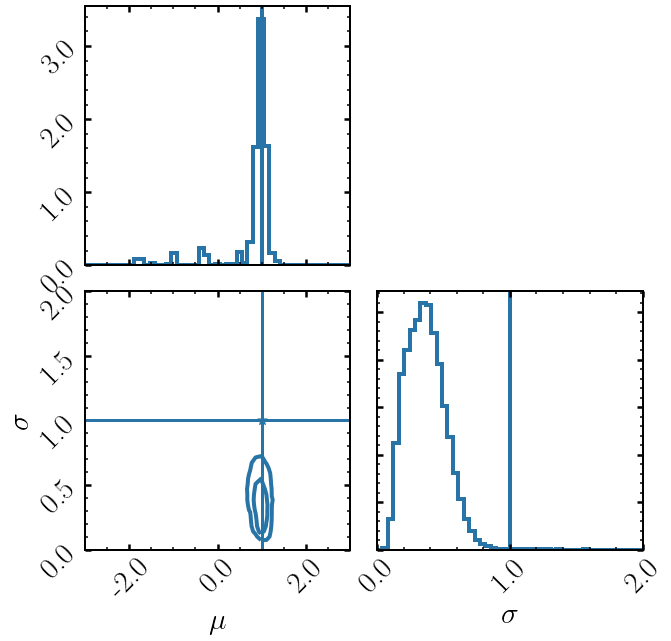

In [911]:
Ndim = 2
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(Ndim,Ndim,wspace=0.1,hspace=0.1)
Nbins = 50
axis = np.array([np.linspace(-3,3,Nbins),np.linspace(0,2,Nbins)])
xlabel = [r'$\mu$',r'$\sigma$']

for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.add_subplot(grid[i,j])

        
colors = ['#2874A6','#b11226']

fill_corner(fig,sampler.flatchain.T,Ndim,axis,colors[0],style=['-'],fill_contours=False,lw=4,true_val=[1,1])
counter = 0
for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.axes[counter]
        if i!=Ndim-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(xlabel[j],fontsize=30)
            ax.set_xticklabels(np.around(ax.get_xticks(),1),rotation=45,fontsize=30)
        if j!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(xlabel[i],fontsize=30)
            ax.set_yticklabels(np.around(ax.get_yticks(),1),rotation=45,fontsize=30)
        counter += 1
        ax.tick_params(axis="both",direction="in",which='major',width=2.5,length=6,right=True,top=True)
        ax.tick_params(axis="both",direction="in",which='minor',width=1.5,length=3,right=True,top=True)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        
fig.axes[0].set_ylabel('')


# Adding selection bias

A very important component we have to understand in population analysis is the selection bias.
In order not to confuse noise with real signal, we often impose cut on the event signficance. This results in not every events in the universe can be detected.
When we infer the parameters of a population, what we want to understand is the true population instead of the observed population. This means we have to adjust our population posterior to account for the selection bias.

In LVC the selection function is measured through conducting injection campaigns. One can set up a virtual GW detector network, simulate a population of events then try detecting the population using the virtual GW detector network. One can impose a cut on the false alarm rate (FAR) to catageorized detected and undetected events, and the ratio between the two is the selection bias. This is once again too expensive for our purpose. We will use an arbitary cut in our case.

The selection bias is defined as 

$$
\alpha(\mathbf{\lambda}) = \int p_{\rm{pop}}(\mathbf{\theta'}|\mathbf{\lambda})p_{\rm{det}}(\mathbf{\theta'})d\mathbf{\theta'} = \frac{N_{\rm det}}{N_{\rm total}},
$$

where $p_{\rm det}(\mathbf{\theta'})$ is the probability of detecting a source with parameters $\mathbf{\theta'}$, $N_{\rm det}$ is the number of detected event, and $N_{\rm total}$ is the number of total event.
The selection bias basically encapsulate the fraction of event that can be detected assuming some total number of event.

### Exercise

1. Write down the form of the population posterior with selection bias (You can forget about measurement error here.)
2. Apply a selection criteria of $x>0.1$ to the original distribution, make a histogram to show the "observed" distribution.
3. Use the population posterior in the first part (without measurement uncertainty and selection bias) to infer the properties of this distribution with selection effect. Do you see the selection bias? Can you explain why the result is biased in that particular direction?
4. Now implement the population posterior with selection bias and use that for the inference. To do this, you need to figure out what is $\alpha(\mathbf{\lambda})$ in our case. How did the posterior changed?

In [839]:
threshold = 0.1

from scipy.special import erfc
def population_likelihood_with_selection(params, data):
    if (params[0]>10) or (params[0]<-10):
        return -np.inf
    if (params[1]>5) or (params[1]<0):
        return -np.inf
    bias = erfc((threshold-params[0])/params[1]/np.sqrt(2))/2
    output = np.sum(np.log(gaussian(data,params[0],params[1])/bias))
    if np.isfinite(output):
        return output
    else:
        return -np.inf


injection_with_selection = injection[injection>threshold]


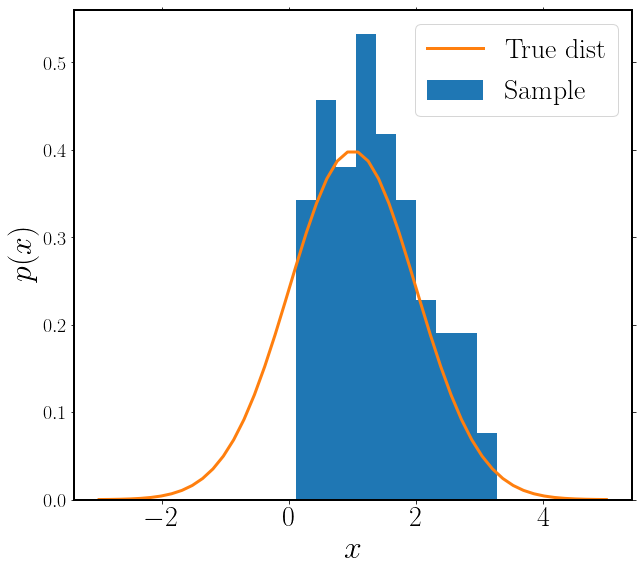

In [840]:
fig, ax = plt.subplots(1,1,figsize=(10,9))
plt.hist(injection_with_selection,density=True,label='Sample')
plt.plot(np.linspace(-3,5),gaussian(np.linspace(-3,5),true_mean,true_sd),lw=3,label='True dist')
plt.xlabel('$x$')
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')

In [841]:
ndim, nwalkers = 2, 100
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_likelihood, args=[injection_with_selection])
sampler.run_mcmc(p0, 1000)

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/home/kaze/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


State([[ 1.48442487  0.85673755]
 [ 1.31052216  0.81649667]
 [-1.65116347 -2.56542667]
 [ 1.34351859  0.86538101]
 [ 1.27201335  0.85098509]
 [ 1.26368743  0.8112888 ]
 [ 1.42871228  0.87155297]
 [ 1.27763829  0.78587477]
 [ 1.38492913  0.83782108]
 [ 1.46323816  0.81321308]
 [ 1.29370949  0.76046204]
 [ 1.3741065   0.7312377 ]
 [ 1.3574833   0.90914942]
 [ 1.34670643  0.77277622]
 [-0.86469039 -1.63525564]
 [ 1.27161467  0.80554115]
 [ 1.5704458  -1.44662346]
 [ 1.40314235  0.8046973 ]
 [ 1.4187216   0.85812619]
 [ 1.31433517  0.78830784]
 [ 1.28074376  0.79596602]
 [ 1.37701156  0.73893405]
 [ 1.49905218  0.82362692]
 [ 1.40840321  0.71750109]
 [ 1.50993356  0.84387205]
 [ 1.34666074  0.67165346]
 [ 1.30847111  0.93418423]
 [ 1.43804978  0.97813696]
 [ 1.40686003  0.86960591]
 [ 2.07694094 -2.48627429]
 [ 1.26391043  0.79932532]
 [ 1.23592212  0.77311841]
 [ 1.40978548  0.79102593]
 [ 1.41193202  0.85601976]
 [ 1.37887243  0.81163597]
 [ 1.34555122  0.82786021]
 [ 1.45620208  0.74285

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, '')

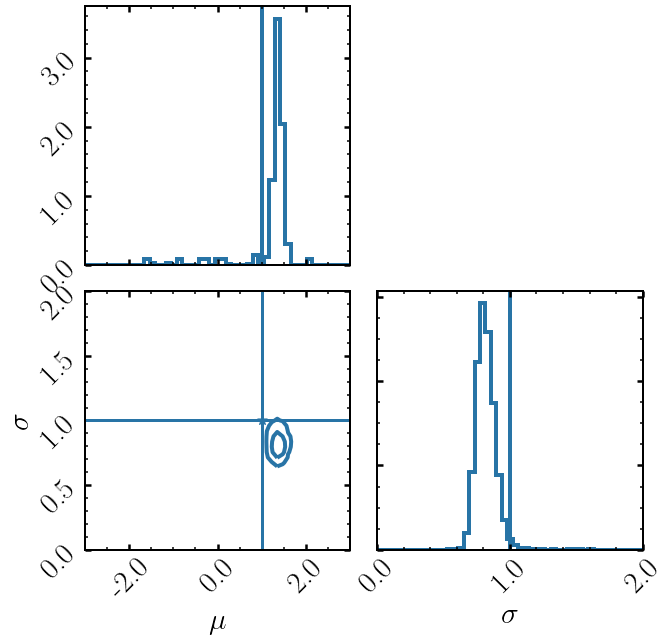

In [842]:
Ndim = 2
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(Ndim,Ndim,wspace=0.1,hspace=0.1)
Nbins = 50
axis = np.array([np.linspace(-3,3,Nbins),np.linspace(0,2,Nbins)])
xlabel = [r'$\mu$',r'$\sigma$']

for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.add_subplot(grid[i,j])

        
colors = ['#2874A6','#b11226']

fill_corner(fig,sampler.flatchain.T,Ndim,axis,colors[0],style=['-'],fill_contours=False,lw=4,true_val=[1,1])
counter = 0
for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.axes[counter]
        if i!=Ndim-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(xlabel[j],fontsize=30)
            ax.set_xticklabels(np.around(ax.get_xticks(),1),rotation=45,fontsize=30)
        if j!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(xlabel[i],fontsize=30)
            ax.set_yticklabels(np.around(ax.get_yticks(),1),rotation=45,fontsize=30)
        counter += 1
        ax.tick_params(axis="both",direction="in",which='major',width=2.5,length=6,right=True,top=True)
        ax.tick_params(axis="both",direction="in",which='minor',width=1.5,length=3,right=True,top=True)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        
fig.axes[0].set_ylabel('')


In [843]:
ndim, nwalkers = 2, 100
ivar = 1. / np.random.rand(ndim)
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, population_likelihood_with_selection, args=[injection_with_selection])
sampler.run_mcmc(p0, 1000)

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/home/kaze/.local/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


State([[ 0.84244271 -1.97403114]
 [ 0.44296965  1.34955626]
 [ 1.23771062  0.89669559]
 [ 1.103953    0.86531436]
 [ 0.9830173   0.99925939]
 [ 1.05718702  0.89601853]
 [ 0.87696554  1.06237939]
 [-0.09444912  1.67804985]
 [ 1.24411165  0.98256594]
 [ 0.94789184  1.12624643]
 [ 1.16406212  0.92859532]
 [ 1.1789317   1.00576671]
 [ 0.69073418  1.47268549]
 [ 1.23096181  1.04083747]
 [ 1.03426357  1.1220326 ]
 [ 1.05016691  1.02747811]
 [ 1.05516754  1.04134693]
 [ 1.0830844   0.92773436]
 [ 1.10950819  1.02848468]
 [ 0.7292566   1.30513602]
 [ 0.72974198  1.24974913]
 [ 1.03147422  1.04067995]
 [ 0.50465948  1.39480837]
 [ 0.66057789  1.40971529]
 [ 0.32390826  1.48643442]
 [ 0.97640742  0.95948836]
 [ 1.06379318  0.95829245]
 [ 0.81241916  1.03679833]
 [ 1.19605416  1.09939559]
 [ 0.66112082  1.21593565]
 [ 0.86548867  1.19933897]
 [ 1.01608059  1.21170927]
 [ 0.52212069  1.41614316]
 [ 0.87964687  1.31467451]
 [ 0.62670322  1.25182821]
 [ 1.10290029  0.98314936]
 [ 1.06544921  0.97498

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, '')

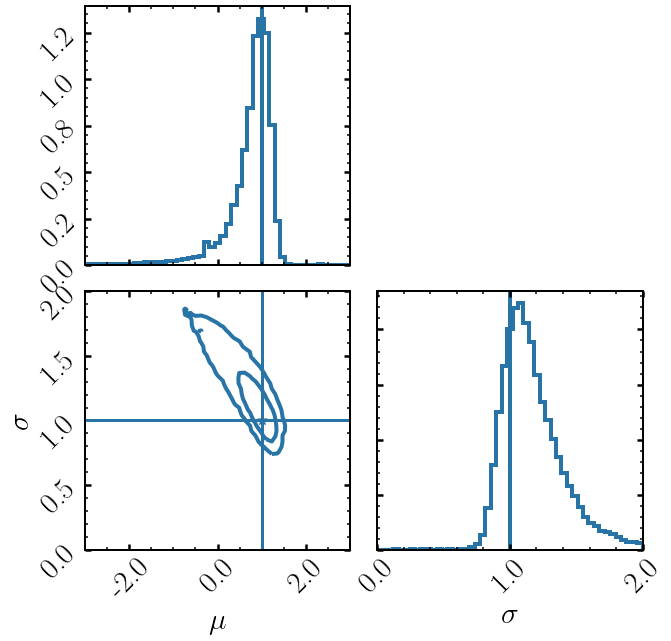

In [844]:
Ndim = 2
fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(Ndim,Ndim,wspace=0.1,hspace=0.1)
Nbins = 50
axis = np.array([np.linspace(-3,3,Nbins),np.linspace(0,2,Nbins)])
xlabel = [r'$\mu$',r'$\sigma$']

for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.add_subplot(grid[i,j])

        
colors = ['#2874A6','#b11226']

fill_corner(fig,sampler.flatchain.T,Ndim,axis,colors[0],style=['-'],fill_contours=False,lw=4,true_val=[1,1])
counter = 0
for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.axes[counter]
        if i!=Ndim-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(xlabel[j],fontsize=30)
            ax.set_xticklabels(np.around(ax.get_xticks(),1),rotation=45,fontsize=30)
        if j!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(xlabel[i],fontsize=30)
            ax.set_yticklabels(np.around(ax.get_yticks(),1),rotation=45,fontsize=30)
        counter += 1
        ax.tick_params(axis="both",direction="in",which='major',width=2.5,length=6,right=True,top=True)
        ax.tick_params(axis="both",direction="in",which='minor',width=1.5,length=3,right=True,top=True)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        
fig.axes[0].set_ylabel('')


# Analysising BBHs in GWTC2

In this session, we will try to analyse the BBHs population in GWTC2. Note that there are a lot of technical detail that I will not be able to cover here, so instead of asking you to do the exercise, I will demonstrate how this is done in a crude way. For convienience, I will use a pre-process data set instead of the raw catalogue given by the LVC. Please feel free to ask me questions about how that is done.

It will take some time for the runs to converge (~1 hr on my laptop with 4 cores)

# Model

We use the truncated powerlaw model from https://arxiv.org/pdf/2010.14533.pdf as our population likelihood. Note that we also need the redshift distribution to compute the selection bias.

In [914]:
z_range = [0.,2.3]
z_axis = np.linspace(z_range[0],z_range[1],500)

def truncated_mass(m1,m2,mmin,mmax,alpha,beta):
    assert m1.shape == m2.shape 
    if (m1<mmax)*(m1>mmin)*(m2<m1):
        return m1**(-alpha-beta)*m2**beta
    else:
        return np.zeros(m1.shape)

def redshift(z,kappa):
    return (1+z)**kappa

def population_likelihood(m1,m2,z,mmin,mmax,alpha,beta,kappa):
    assert m1.shape == m2.shape 
    p_m = m1**(-alpha-beta)*m2**beta
    p_m[(m1>mmax)+(m1<mmin)+(m2>m1)] = 0
    p_z = (1+z)**(kappa-1)*Planck15.differential_comoving_volume(z).to(u.Gpc**3/u.sr).value
    norm_mass = ((1 + alpha)*mmax**(alpha + beta)*mmin**2 - (-1 + alpha + beta)*mmax**(2 + alpha)*mmin**beta + (-2 + beta)*mmax*mmin**(1 + alpha + beta))/((1 + alpha)*(-2 + beta)*(-1 + alpha + beta)*mmax**alpha*(mmax*mmin)**beta)
    norm_z = np.trapz((1+z_axis)**(kappa-1)*Planck15.differential_comoving_volume(z_axis).to(u.Gpc**3/u.sr).value)
#     print(norm_mass,norm_z)
    return p_m*p_z/norm_mass/norm_z



# Selection Bias

We follow the note in 
https://dcc.ligo.org/LIGO-P2000434/public
https://dcc.ligo.org/LIGO-P2000217/public
to compute the selection bias.

The number 7.1 * 1e7 is Ndraw for O12, which I got from here https://arxiv.org/pdf/2010.14533.pdf

In [846]:
O12 = h5py.File('./injections_O1O2an_spin.h5','r')
O3 = h5py.File('./o3a_bbhpop_inj_info.hdf','r')
O3_selection= (O3['injections/ifar_gstlal'][()]>1) | (O3['injections/ifar_pycbc_bbh'][()]>1) | (O3['injections/ifar_pycbc_full'][()]>1)
m1 = np.append(O12['mass1_source'][()],O3['injections/mass1_source'][()][O3_selection])
m2 = np.append(O12['mass2_source'][()],O3['injections/mass2_source'][()][O3_selection])
z = np.append(O12['redshift'][()],O3['injections/redshift'][()][O3_selection])
pdraw = np.append(O12['sampling_pdf'][()],O3['injections/sampling_pdf'][()][O3_selection])
samples = np.array([m1,m2,z]).T
Ndraw = O3.attrs['total_generated']+7.1*1e7

In [847]:
def evaluate_selection(mmin,mmax,alpha,beta,kappa):
    likelihood = population_likelihood(m1,m2,z,mmin,mmax,alpha,beta,kappa)
    return np.sum(likelihood/pdraw)/Ndraw

# Data 

Here we import the pre-process GWTC2 data. We need two entries in the .npz files, the first one is the posterior sample for the events, which is a 3D array that has the shape (n_event,n_sample,n_parameter). The other entry we need is the prior value at the location of those posterior samples, which has the shape (n_event, n_sample)

In [919]:
data = np.load('./GWTC12_m1m2z_highsig.npz')
posterior = data['posterior_sample']
prior = data['prior'][:,:,0]
N_event = prior.shape[0]

# Inference

Now we write a wrapper of the posterior for the emcee sampler. We use a uniform population prior, which is constant within the range of interest and 0 otherwise.

In [922]:
mmin_range = [2,10]
mmax_range = [60,100]
alpha_range = [0,10]
beta_range = [-6,6]

def population_posterior(params,posterior,prior):
    mmin = params[0]
    mmax = params[1]
    alpha = params[2]
    beta = params[3]
    if (mmin>mmin_range[1]) or (mmin<mmin_range[0]):
        return -np.inf
    if (mmax>mmax_range[1]) or (mmax<mmax_range[0]):
        return -np.inf
    if (alpha>alpha_range[1]) or (alpha<alpha_range[0]):
        return -np.inf
    if (beta>beta_range[1]) or (beta<beta_range[0]):
        return -np.inf
    else:
        pop_like = population_likelihood(posterior[...,0],posterior[...,1],posterior[...,2],mmin,mmax,alpha,beta,1)
        pop_like = np.sum(np.log(np.mean(pop_like/prior,axis=1)))
        selection = np.log(evaluate_selection(mmin,mmax,alpha,beta,1))*N_event
        print(pop_like,selection)
        return pop_like-selection

In [923]:
ndim, nwalkers = 4, 30
ivar = 1. / np.random.rand(ndim)
p0 = np.random.uniform([mmin_range[0],mmax_range[0],alpha_range[0],beta_range[0]], [mmin_range[1],mmax_range[1],alpha_range[1],beta_range[1]],size=(nwalkers,ndim))


with Pool() as pool:

    sampler = emcee.EnsembleSampler(nwalkers, ndim, population_posterior, args=[posterior,prior],pool=pool)
    sampler.run_mcmc(p0, 100)

-3414.169125553453

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


 -1916.0557462918619
-2853.018745404202 -1462.0634042904567
-inf -1695.8042017652745
-3312.0112236156274 -1843.5153977219936
-2620.4450744755136 -1102.7941286526461
-1855.1633872551183 -1783.27011575157-509.69353097925915 
-427.75042643694496
-3033.4961390350923 -1607.3107625717423
-2517.43755309917 -946.8714988596437
-1913.7397004925274 -579.5379011829982
-2684.8953804867733 -1184.0773583233733
-1878.0306802697537 -494.88456101627116
-3505.9082041870056 -1952.7167208273902
-3212.9522022756164 -1565.5995108813397
-1815.21822690559 -455.94371228385137
-2846.587893530652 -1292.7705349485004
-3441.9289293810575 -1752.0194960486222
-2930.5958891503687 -1491.9132638025737
-3426.8128044217265 -1953.8795974415843
-2920.782060759098 -1481.9146980434753
-2020.8502882559865 -657.2480124472803
-1946.415310952067 -542.5764457450003
-2541.583093478018 -903.9128370482406
-2193.9181130727206 -855.7074558303782
-1291.08381879858 76.80658680346752
-1923.665464579891 -556.3189639767212
-3619.45875866298

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


-3171.2382684464 -1736.6247246316848
-2984.1332510075163 -1552.67336208887
-inf -1964.276926729397
-2312.9328591656727 -861.7764423326896
-2292.368812400254 -944.5572254602587
-2518.7806146794346 -1080.2702621679489
-2505.0861034787536 -1095.9270603221937
-2638.7381841937563-2784.718349823455  -1129.7735278875002
-1404.9445351164027
-2227.962352097923 -869.4015934672796
-1970.9136902002144-2662.113393490004  -1168.3267061430304-622.2873559186291

-2913.2302907369804 -1472.2936951284064-2609.3510199352754 
-1125.6646718025193
-2739.841488565522 -1370.1109916243738
-2028.10919155638 -697.1650723043867
-2445.335829371312 -1051.5453693312113
-1916.6897414525024 -584.1014137171913
-2263.1696940331935 -910.7686859110838
-1994.0399302285239 -646.2734287333138
-2527.2557724705534 -1128.5140751630922-2689.7697703917133
-2505.2060914568133  -1267.5856999681857-1146.9383840580983

-2535.702414173181 -1131.6052478496417
-1861.4957858243433 -530.0506918769114-2902.163209294471 
-1412.027151553989
-

-1935.7271190837107 -590.9081664420962
-1727.188652202383 -393.9260376823221-2658.2993831485555
-2705.6013969746828  -1333.632485972801-1235.04903183381

-2303.1056982164823 -965.9849388675046
-2410.6544267750196 -1044.6905579004622
-1907.4862403948678 -574.4998087963553
-2414.532587463682 -1055.0772129751902
-2634.7516231839118 -1257.2966771731255
-2131.4043805594138 -798.7452887554979
-2285.4196331665935 -926.7180131231498
-2153.2207204015453 -814.5394672485326
-2329.3667280999766 -995.3178679236178
-2134.2107169153255 -801.8447856865872
-1988.0704596659602 -652.9432088749282
-1908.2823853925338 -572.6145190345337
-2356.4008485967865-1891.7330556662012  -1022.4965753493077-1808.8417444059028-553.8852153300519
 
-475.4629224906632
-1856.8545629866594 -524.3649108596248
-2410.507738605884-2808.9118272432165  -1026.8214541633042-1388.6923417719813

-2270.8446138964437 -913.8079289094848
-1945.9089102181863 -612.6236624189235
-1877.110976892532 -544.2858648600503
-2151.249532442137 -818.

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


-inf -825.1380315529384
-2388.5510707952544 -2317.8845382158784 -1051.099297385181-982.0229561835903-1924.7319940646148

 -552.7100970553851
-1938.1877739189 -605.1667743118016
-2100.4252197809296 -752.5789082858732
-2250.057763656389 -906.5788868817108
-2356.4455736971972 -1008.3528871343443
-1978.2426025138666 -645.7234154589373
-2193.886823455577 -863.63155348189
-1773.8969719708655 -441.04556439423897
-1705.8138686622653 -369.77336191848906
-2387.6568307539465 -1050.237737082011
-2122.022926648559 -2155.839493896117-773.1277986126985 
-821.8904582657622
-2173.2255832166084 -843.5147598357668


/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


-inf -856.8574925618225
-2350.0764139637613 -1004.7775736087176-1916.7009574501371
 -583.8021853800415
-2336.0800466889646 -1001.8104798128032
-2201.1104633028667 -867.5848335688685
-2175.5633033685517 -845.6403742255404
-1760.4667267896423 -427.46954372150594
-1911.4322360220285 -580.3327911497131
-2338.747158207571 -995.3055873435214
-1735.3362890917 -390.63187704158713
-2247.895939109229 -1743.3708616696017-915.1868697609588
 -409.3818970737613
-1988.81890620209 -658.0523910704458
-1979.5009112390862 -646.068919109347
-2209.874794020378 -878.9857486258478
-2045.1612114181494 -710.4587323121734
-1990.552723361915 -659.8202151509049
-2296.4295962483247 -963.4892856475659
-1898.7273429565303 -567.0147029451974
-2055.217243943807 -720.0583535406998
-2246.3653551213133 -909.910285122977
-1689.8054512325675 -353.54073277712376
-2178.225711954935 -1684.2982736921474-848.4700124270468
 -350.2608657003027
-2212.713970380152 -881.7727188465973
-2209.1684364820685 -845.783123191292
-2115.20764

-2298.3970618599883 -965.4525631301403
-1947.6360229261502 -616.5629436829976
-1964.2269206511485 -633.5127341160089
-2316.851749321537 -984.0389428425258
-inf -2460.3171417142325-529.3021385849701 -1122.8245071167698

-1978.5191106996592 -643.7315570552286
-2013.0068293182474 -678.3674343842988
-2106.2452102422703 -776.414081610898
-1548.8953483998025 -215.5582844942109
-2261.487887890931 -912.3726839353155
-2037.2748606473615 -706.436966987595
-2288.149320820988 -956.901157163303
-1953.260451338255 -621.1576267715914
-1819.2120401921109 -486.7733866415708
-1963.0116826663-1913.0226078751043 -2114.2062390865794 -632.2451783439851
 -579.1162051718519-784.8027597434578

-2154.5754867495084 -817.3390320710316
-2383.93432148433 -1049.8123187978028-2096.105505389944
 -2731.829694503208 -1368.568424864586-763.1866871363375

-1967.9413263335414 -635.6794772193035
-2311.151892408558 -979.3374101646635
-2365.0700165257354 -1029.756690687272
-1950.8361613874165 -619.0917109644374
-2221.12576024

-1928.7164172423254 -598.5087589311664
-2066.605170046443 -735.1765386716836
-2229.540251450662 -897.1500591490704
-1934.0736450960153 -600.8714060199766
-2124.9058514947446 -2033.129973915019-794.1461008764848 
-703.5810555199024
-2050.931852952925 -720.2896998426108
-2069.9133912180887 -740.2757860483621
-1929.5724449877764 -598.2106156458414
-1911.176194767229 -577.4135400663898
-2246.73250063141 -2086.686425781363-915.4247122506798 -752.3309951487583

-1831.4507748625972 -499.9566360600075
-2299.1111816899715-2125.237650708689 -966.9888858963217 
-793.8962360129362
-2022.4409011653747-2181.6672048428304  -692.8712907514758-849.4453276637392

-1925.9670650940902 -594.4209298185267
-2207.704416466216 -877.1810694099381
-1926.9595585555458 -595.9208942711452
-2088.707157943129 -2206.0630516149895 -758.6749497716991
-874.7621623288354
-2321.965123460228 -983.2793045565197
-2071.3532060121465 -739.9634056172753-2274.4392875154067
 -935.6227754754259
-1960.5011216657974 -629.01061537114


-2029.6004016228055 -700.1098132216965-2173.580537444065
 -843.166554600072
-1994.4676437752278 -664.8750550341662
-2069.478771113825 -735.8113875709641
-2074.5279392614216 -737.8552249334206-2074.9676386238275
 -742.7258733905524
-2368.692503075884 -1033.9465143932605
-2148.627039503841-2110.666437965091  -817.6959963086255-778.9507567273718

-2017.9523380294345 -687.7663508872358
-2059.593458196313 -729.364419948153
-1970.8232887514755 -641.0121011945297-2119.696161164372
 -1855.2394883722982-787.6004475076077 
-524.4171288696483-1889.9385785115087 -558.9135767979265

-2210.793532558282 -869.4784781872514
-1863.391742930568 -529.9326733883007
-2015.5739060781425 -684.307771933272
-2280.0173854937466 -948.094394571518
-2279.102315094647 -948.0406883586073
-1897.0141198130445 -565.4602826953364
-2218.207736856605 -888.1340543332809
-2007.398671228375 -676.5603394411013
-2052.015147281351 -722.2281360364508
-2172.656743750292 -841.8664072657015
-1910.915672281559 -580.8534893932476-2147

KeyboardInterrupt: 

/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/kaze/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0, 0.5, '')

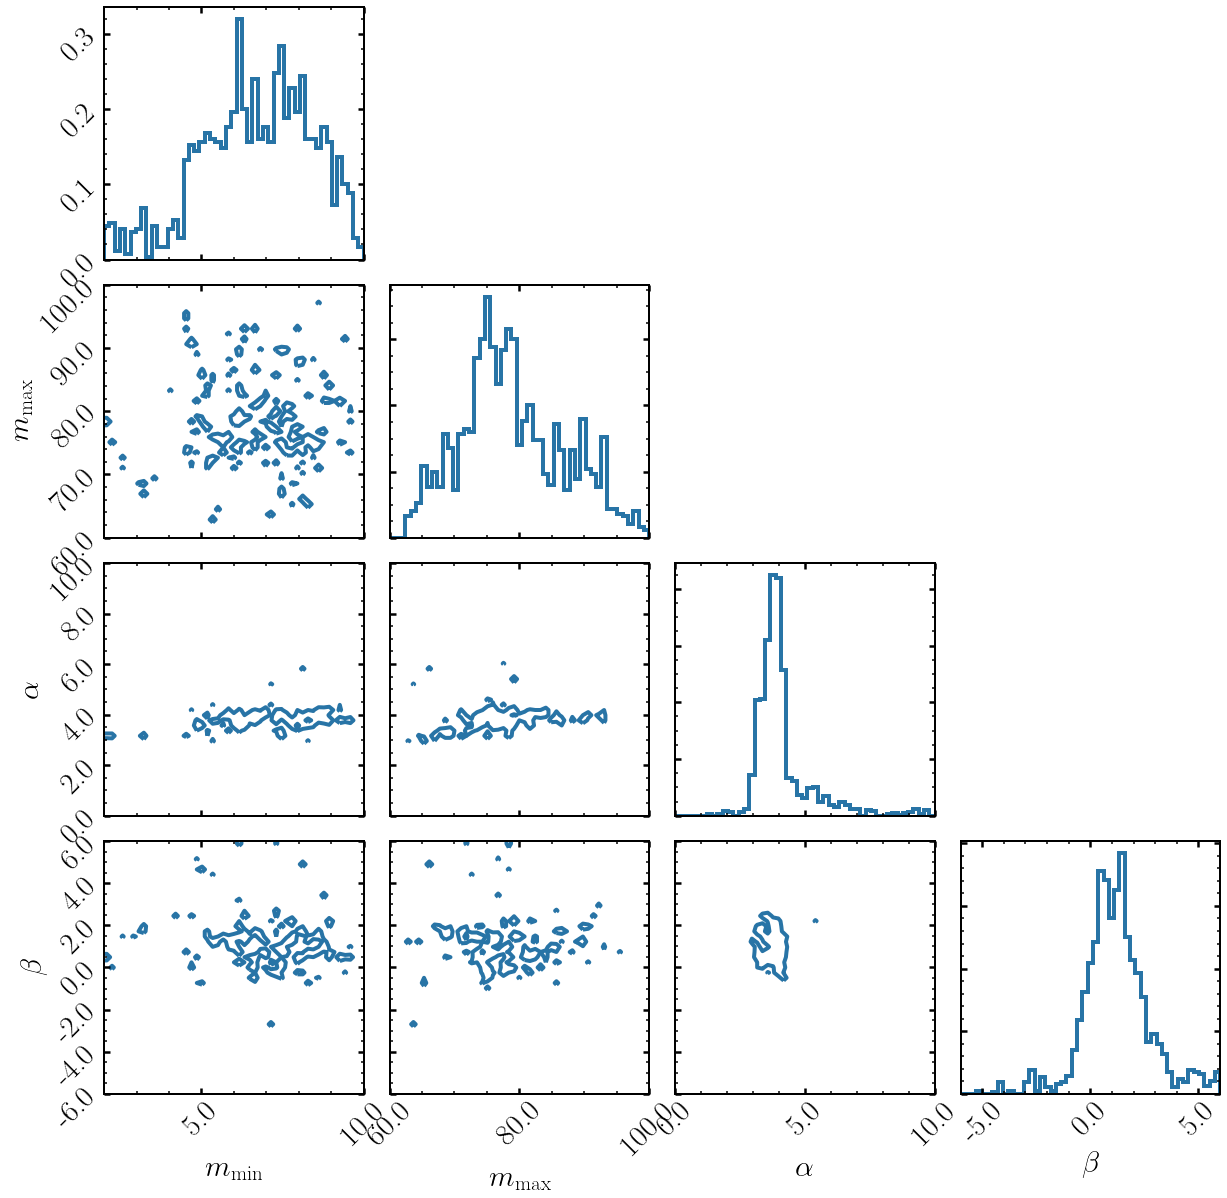

In [932]:
Ndim = 4
fig = plt.figure(figsize=(20,20))
grid = plt.GridSpec(Ndim,Ndim,wspace=0.1,hspace=0.1)
Nbins = 50
axis = np.array([np.linspace(2,10,Nbins),np.linspace(60,100,Nbins),np.linspace(0,10,Nbins),np.linspace(-6,6,Nbins)])
xlabel = [r'$m_{\rm min}$',r'$m_{\rm max}$',r'$\alpha$',r'$\beta$']

for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.add_subplot(grid[i,j])

        
colors = ['#2874A6','#b11226']

fill_corner(fig,sampler.flatchain.T,Ndim,axis,colors[0],style=['-'],fill_contours=False,lw=4,levels=[0.6])
counter = 0
for i in range(Ndim):
    for j in range(i+1):      
        ax = fig.axes[counter]
        if i!=Ndim-1:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(xlabel[j],fontsize=30)
            ax.set_xticklabels(np.around(ax.get_xticks(),1),rotation=45,fontsize=30)
        if j!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(xlabel[i],fontsize=30)
            ax.set_yticklabels(np.around(ax.get_yticks(),1),rotation=45,fontsize=30)
        counter += 1
        ax.tick_params(axis="both",direction="in",which='major',width=2.5,length=6,right=True,top=True)
        ax.tick_params(axis="both",direction="in",which='minor',width=1.5,length=3,right=True,top=True)
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

        
fig.axes[0].set_ylabel('')

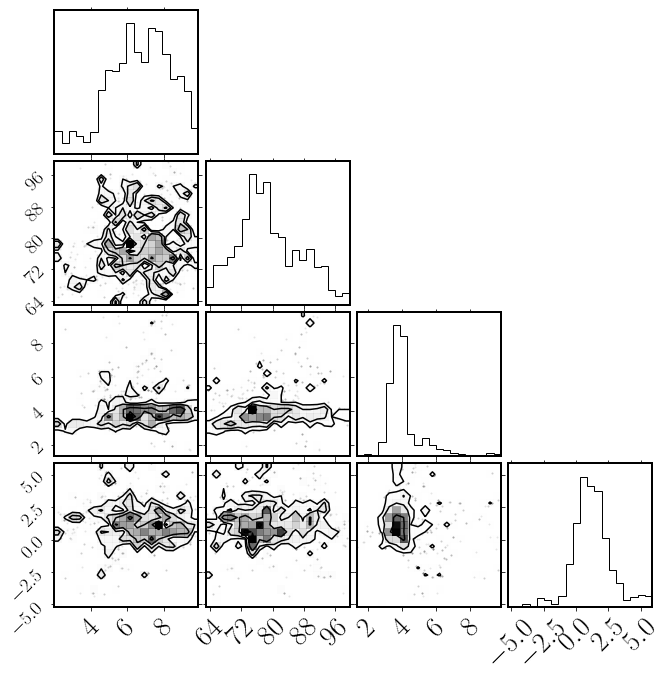

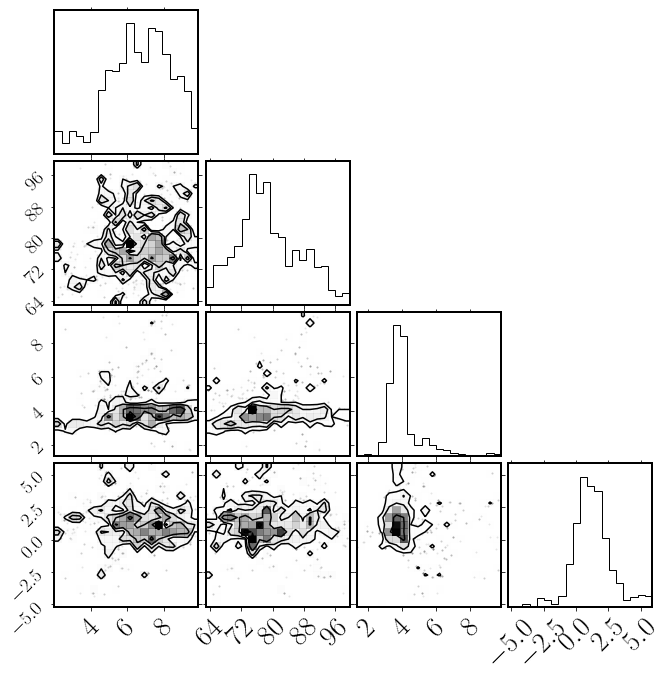

In [933]:
corner.corner(sampler.flatchain)